<div style="text-align: center;">
    <h1>Modellerstellung für die Vorhersage von Hotelstornierungen</h1>
    <p><b>Name:</b> Tommi Jlassi</p>
    <p><b>Matrikelnummer:</b> XX</p>
    <p><b>Datum:</b> 28. August 2025</p>
    <p><b>Kurs:</b> Machine Learning</p>
</div>


<h2 style="color:black;font-family: 'Times New Roman', Times, serif;">Inhaltsverzeichnis</h2>
<ol style="color:black; line-height: 1.5;">
    <li><a href="#kapitel1" style="color:black;font-family: 'Times New Roman', Times, serif;">Betrachte das Gesamtbild</a></li>
    <li><a href="#kapitel2" style="color:black;font-family: 'Times New Roman', Times, serif;">Datenbeschaffung und Visualisierung</a></li>
    <li><a href="#kapitel3" style="color:black;font-family: 'Times New Roman', Times, serif;">Datenaufbereitung</a></li>
    <li><a href="#kapitel4" style="color:black;font-family: 'Times New Roman', Times, serif;">Bereite die Daten für Machine-Learning-Algorithmen vor</a></li>
    <li><a href="#kapitel5" style="color:black;font-family: 'Times New Roman', Times, serif;">Wähle ein Modell aus und trainiere es</a></li>
    <li><a href="#kapitel6" style="color:black;font-family: 'Times New Roman', Times, serif;">Verfeinere das Modell</a></li>
    <li><a href="#kapitel7" style="color:black;font-family: 'Times New Roman', Times, serif;">Präsentiere die Lösung</a></li>
    <li><a href="#kapitel8" style="color:black;font-family: 'Times New Roman', Times, serif;">In Betriebnahme</a></li>
</ol>


<a id="kapitel1" style="color:black"><h2>1. Betrachtung des Gesamtbilds</h2></a> 

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Die vorliegende Arbeit untersucht die Möglichkeiten, mithilfe von Datenanalyse und Machine Learning geschäftsrelevante Vorhersagen zu treffen. 
Im Mittelpunkt steht die Fragestellung, ob bevorstehende Hotelreservierungen storniert werden oder nicht, sowie die Wahrscheinlichkeit eines solchen Stornofalls. 
Eine verlässliche Prognose in diesem Bereich ist für Hotelbetreiber von großem Nutzen, da sie eine effizientere Personal- und Ressourcenplanung, gezielte Marketingmaßnahmen sowie die Reduzierung finanzieller Ausfälle ermöglicht.
</p>

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Ausgehend von diesem Ziel wird zunächst ein Gesamtüberblick der Daten vorgestellt, diese analysiert und für den Einsatz von Machine-Learning-Algorithmen aufbereitet. 
Im nächsten Schritt erfolgt die Auswahl der Daten, das Training und die Verfeinerung eines geeigneten Modells. 
Für diese Arbeit liegt der Fokus auf den Modellen <i>Random Forest</i> und <i>Linear Regression</i>. 
Sinnvoll wären auch weitere Verfahren wie beispielsweise <i>Support Vector Machines</i> oder <i>Gradient Boosting</i> zu erproben, um ein noch breiteres Bild der Vorhersageleistung zu erhalten. Für die vorliegende Arbeit wurde jedoch eine Eingrenzung auf die beiden genannten Modelle vorgenommen, da sie einerseits unterschiedliche methodische Ansätze repräsentieren und andererseits eine gute Balance zwischen Interpretierbarkeit und Prognosequalität versprechen. Abschließend werden die Ergebnisse präsentiert und die praktischen Einsatzmöglichkeiten diskutiert.
</p>


<a id="kapitel2" style="color:black"><h2>2. Datenbeschaffung</h2></a> 

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
<strong>Ziel:</strong> In diesem Kapitel werden die verwendeten Datenquellen vorgestellt sowie die Eigenschaften der Rohdaten beschrieben.
</p>

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Die für diese Arbeit verwendeten Daten stammen von der Plattform <i>Kaggle</i> und sind über den folgenden Datensatz zugänglich: 
<a href="https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction" target="_blank">Reservation Cancellation Prediction Dataset</a>. 
Es handelt sich um historische Buchungsdaten eines Hotels, die Angaben zu Reservierungen sowie deren Status (storniert oder nicht storniert) enthalten. 
Damit bilden sie die Grundlage für die Entwicklung und das Training von Machine-Learning-Modellen zur Vorhersage von Stornierungen.
</p>

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Der Datensatz enthält sowohl numerische als auch kategoriale Merkmale, beispielsweise Informationen zur Aufenthaltsdauer, zur Anzahl der Gäste, zum gebuchten Zimmertyp, zu Zahlungsbedingungen und zu Marketingkanälen. 
Diese Vielfalt an Attributen ermöglicht es, unterschiedliche Einflussfaktoren auf eine mögliche Stornierung zu analysieren und in die Modellbildung einzubeziehen. 
Die Daten liegen im CSV-Format vor und werden im Rahmen der Arbeit mit der Python-Bibliothek <i>pandas</i> importiert und weiterverarbeitet.
</p>


In [70]:
import pandas as pd
df = pd.read_csv("train_dataset.csv")


<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Die Daten werden nach dem Import zunächst mit verschiedenen Funktionen in Python gesichtet, um einen ersten Überblick zu erhalten. 
So können grundlegende Eigenschaften wie die Größe des Datensatzes, die enthaltenen Spalten, die Datentypen sowie die ersten Zeilen betrachtet werden. 
Dies dient dazu, ein besseres Verständnis für die Struktur der Daten zu entwickeln und mögliche Auffälligkeiten frühzeitig zu erkennen.
</p>


In [71]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,4,0,0,0,118,2017,12,28,1,0,0,0,110.80,2,0
1,2,1,0,2,0,0,0,17,2018,4,14,1,0,0,0,145.00,0,1
2,1,0,1,5,0,0,0,349,2018,10,4,0,0,0,0,96.67,0,1
3,1,0,2,4,0,0,0,69,2018,6,12,0,0,0,0,120.00,0,1
4,2,0,0,4,1,0,0,11,2018,1,20,1,0,0,0,69.50,1,0


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18137 entries, 0 to 18136
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          18137 non-null  int64  
 1   no_of_children                        18137 non-null  int64  
 2   no_of_weekend_nights                  18137 non-null  int64  
 3   no_of_week_nights                     18137 non-null  int64  
 4   type_of_meal_plan                     18137 non-null  int64  
 5   required_car_parking_space            18137 non-null  int64  
 6   room_type_reserved                    18137 non-null  int64  
 7   lead_time                             18137 non-null  int64  
 8   arrival_year                          18137 non-null  int64  
 9   arrival_month                         18137 non-null  int64  
 10  arrival_date                          18137 non-null  int64  
 11  market_segment_

In [73]:
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000,18137.000000
mean,1.846777,0.107515,0.811104,2.208965,0.318465,0.031648,0.336770,85.377405,2017.820698,7.432762,15.660804,0.806197,0.025087,0.022440,0.151403,103.478868,0.617522,0.327618
std,0.516020,0.408901,0.873470,1.426365,0.629140,0.175066,0.772865,86.611736,0.383616,3.076999,8.772788,0.645972,0.156393,0.370078,1.714135,35.474103,0.787941,0.469357
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.300000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.450000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,127.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,120.270000,1.000000,1.000000
max,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


<a id="kapitel2_1" style="color:black"><h3>2.1 Eigenschaften des Datensatzes</h3></a> 

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Der Datensatz besteht aus insgesamt 18.137 Einträgen und umfasst 18 Merkmale. 
Es handelt sich um historische Hotelbuchungen, bei denen jeweils vermerkt ist, ob die Reservierung storniert wurde oder nicht. 
Die Zielgröße ist <span style="color:gray">booking_status</span>, wobei 1 eine Stornierung und 0 eine nicht stornierte Buchung kennzeichnet.
</p>

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Die Merkmale lassen sich in verschiedene Bereiche einteilen:
</p>

<ul style="line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
  <li><strong>Gäste und Aufenthalt:</strong> 
      <span style="color:gray">no_of_adults</span>, 
      <span style="color:gray">no_of_children</span>, 
      <span style="color:gray">no_of_weekend_nights</span>, 
      <span style="color:gray">no_of_week_nights</span>. 
      Diese Angaben beschreiben, wie viele Personen angereist sind und wie lange der Aufenthalt dauern sollte.</li>
      
  <li><strong>Buchungsdetails:</strong> 
      <span style="color:gray">type_of_meal_plan</span>, 
      <span style="color:gray">room_type_reserved</span>, 
      <span style="color:gray">market_segment_type</span>, 
      <span style="color:gray">required_car_parking_space</span>. 
      Hier werden unter anderem die Verpflegungsart, der gebuchte Zimmertyp sowie der Vertriebskanal festgehalten.</li>
      
  <li><strong>Vergangenheit des Gastes:</strong> 
      <span style="color:gray">repeated_guest</span>, 
      <span style="color:gray">no_of_previous_cancellations</span>, 
      <span style="color:gray">no_of_previous_bookings_not_canceled</span>. 
      Diese Merkmale zeigen, ob es sich um einen wiederkehrenden Gast handelt und wie sein bisheriges Buchungsverhalten aussah.</li>
      
  <li><strong>Zeitliche Angaben:</strong> 
      <span style="color:gray">lead_time</span>, 
      <span style="color:gray">arrival_year</span>, 
      <span style="color:gray">arrival_month</span>, 
      <span style="color:gray">arrival_date</span>. 
      Diese Variablen beziehen sich auf den Buchungszeitpunkt und den geplanten Anreisetermin.</li>
      
  <li><strong>Preis und Wünsche:</strong> 
      <span style="color:gray">avg_price_per_room</span>, 
      <span style="color:gray">no_of_special_requests</span>. 
      Sie geben Aufschluss über den Zimmerpreis und eventuelle Sonderwünsche der Gäste.</li>
</ul>




<a id="kapitel2_2" style="color:black"><h3>2.3 Deskriptive Analyse</h3></a> 







<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Für ein besseres Verständnis ist es hilfreich die Daten zu visualisieren. Hierfür wird ein Histogramm verwendet.
</p>


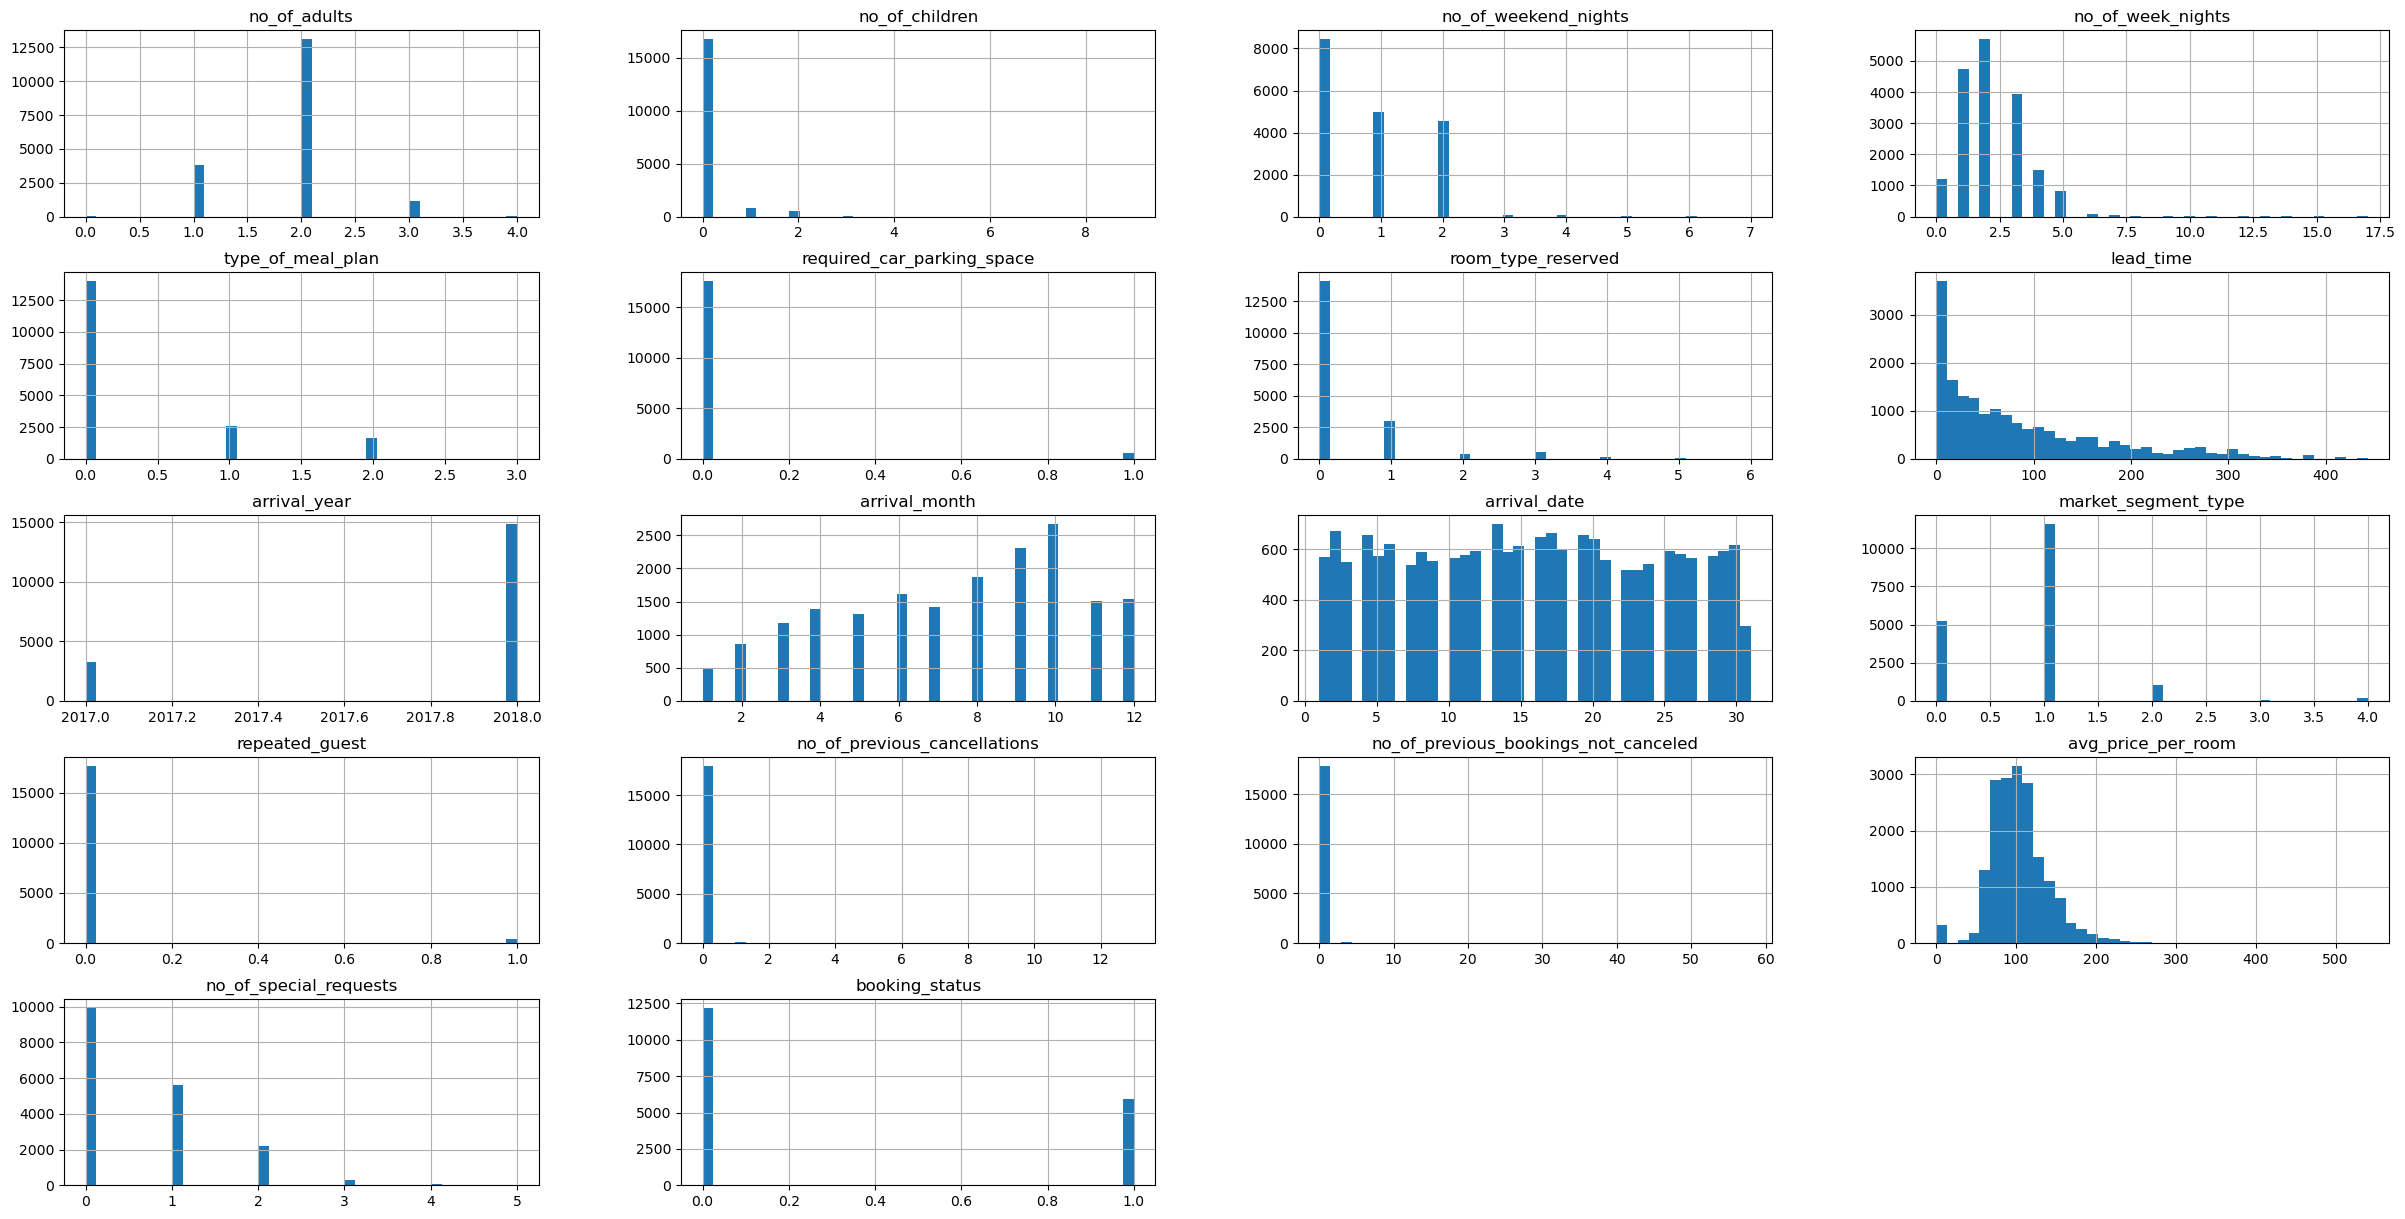

In [74]:
df.hist(bins=40, figsize=(30,15))
plt.show()

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Die numerischen Merkmale, wie zum Beispiel <span style="color:gray">lead_time</span> oder <span style="color:gray">avg_price_per_room</span>, zeigen deutliche Unterschiede in ihrer Verteilung. 
Bei <span style="color:gray">lead_time</span> fällt eine stark rechtsschiefe Verteilung auf, was bedeutet, dass die meisten Buchungen kurzfristig erfolgen, während nur wenige Gäste sehr lange im Voraus reservieren. 
Das Merkmal <span style="color:gray">avg_price_per_room</span> liegt überwiegend in einem mittleren Bereich. 
Auffällig sind einige Werte mit 0, die entweder fehlerhaft erfasst wurden oder aber durch Sonderaktionen, Rabatte oder spezielle Marketingmaßnahmen entstanden sein könnten.
</p>

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Bei den kategorialen Merkmalen, wie <span style="color:gray">type_of_meal_plan</span>, <span style="color:gray">room_type_reserved</span> oder <span style="color:gray">market_segment_type</span>, zeigt sich, dass manche Kategorien deutlich häufiger vorkommen als andere. 
Am häufigsten scheint ein Standard-Zimmertyp gebucht worden zu sein, während spezielle Kategorien eher selten gewählt werden. 
Da der Datensatz keine genaue Erklärung der Kodierungen enthält, kann lediglich vermutet werden, dass die Kategorie 0 jeweils die Standardauswahl darstellt. 
Ähnlich verhält es sich bei den Verpflegungsarten, wo ein Basis- oder Standard-Plan dominiert.
</p>

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Besonders wichtig für die spätere Modellierung ist die Zielvariable <span style="color:gray">booking_status</span>. 
Der Datensatz umfasst sowohl stornierte als auch nicht stornierte Buchungen, allerdings nicht in gleicher Häufigkeit. 
Dieses Ungleichgewicht zwischen den beiden Klassen muss bei der Aufteilung in Trainings- und Testdaten berücksichtigt werden, damit die Modelle nicht einseitig lernen.
</p>

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Zusammenfassend lässt sich festhalten, dass der Datensatz sowohl numerische als auch kategoriale Merkmale enthält, die unterschiedliche Aspekte einer Hotelbuchung abbilden. 
Einige Variablen, wie <span style="color:gray">lead_time</span> oder <span style="color:gray">avg_price_per_room</span>, weisen Ausreißer und eine ungleichmäßige Verteilung auf. 
Bei den kategorialen Merkmalen dominieren bestimmte Kategorien, während andere nur selten vorkommen. 
Zudem zeigt die Zielvariable <span style="color:gray">booking_status</span>, dass ein Klassenungleichgewicht zwischen stornierten und nicht stornierten Buchungen besteht, was im weiteren Modellierungsprozess berücksichtigt werden muss.
</p>


<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Beim Merkmal <span style="color:gray">avg_price_per_room</span> sind einige Werte mit 0 aufgefallen. 
Da es sich hierbei vermutlich um fehlerhafte Einträge oder Sonderfälle handelt wurde wurde diese Zeilen vorerst entfernt. 
Der Datensatz wird dadurch zwar um 284 Buchungen kleiner, aber für die weitere Analyse ist ein Verlust von 1,57% vertretbar. 
Der mögliche Informationsverlust wird an dieser Stelle bewusst in Kauf genommen, um eine konsistente Datenbasis zu erhalten.
</p>


In [75]:
(df["avg_price_per_room"] == 0).sum()

np.int64(284)

In [76]:
df = df[df["avg_price_per_room"] != 0].copy()

<a id="kapitel3" style="color:black"><h2>3. Datenaufbereitung</h2></a> 

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
In diesem Kapitel werden die Daten für die weitere Arbeit vorbereitet. 
Ziel ist es, die Merkmale so zu strukturieren und zu verarbeiten, dass sie optimal für den Einsatz in Machine-Learning-Modellen genutzt werden können. 
Dazu gehört zunächst das Aufteilen des Datensatzes in Trainings- und Testdaten, um eine unabhängige Bewertung der Modelle zu ermöglichen. 
Darüber hinaus werden verschiedene Methoden ausprobiert, um die Daten zu bereinigen, zu transformieren und geeignete Features auszuwählen. 
Auf diese Weise entsteht ein besseres Verständnis dafür, wie die Daten beschaffen sind und wie sie für die Modellierung am sinnvollsten eingesetzt werden können.
</p>


In [77]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["booking_status"])   # Features
y = df["booking_status"]                  # Zielvariable

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size=0.2, stratify=df["booking_status"], random_state=42)


In [78]:
corr_view = Xtrain.copy()

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Für einige Merkmale wurde sich entschieden, diese in binärer Form darzustellen. 
Dazu gehören <span style="color:gray">no_of_weekend_nights</span>, <span style="color:gray">no_of_previous_cancellations</span>, <span style="color:gray">no_of_children</span> und <span style="color:gray">room_type_reserved</span>. 
Der Gedanke dahinter ist, dass die genaue Anzahl in diesen Variablen oft weniger wichtig ist, sondern eher, ob das Merkmal überhaupt vorkommt oder nicht. 
Es reicht also zu wissen, dass Kinder mitreisen, während die genaue Anzahl wahrscheinlich keinen großen Unterschied macht. 
Mit der binären Darstellung wird dies einfach abgebildet: 0 bedeutet nicht vorhanden und 1 bedeutet vorhanden.
</p>



In [79]:
def binarize_features(df, columns):
    df = df.copy()
    for col in columns:
        if col in df.columns:
            df["n_" + col] = (df[col] > 0).astype(int)
        else:
            print(f"{col} nicht gefunden")
    return df

In [80]:
corr_view=binarize_features(corr_view, ["no_of_weekend_nights","no_of_previous_cancellations","no_of_children","room_type_reserved"])

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Neben der binären Darstellung einzelner Merkmale wurde sich auch entschieden, bestimmte Variablen in Gruppen zusammenzufassen. 
Der Gedanke dahinter ist, dass sehr kleine Randgruppen („marginale Gruppen“) leicht ein statistisches Bias erzeugen können, wenn sie in den Daten zu selten vorkommen. 
So wird <span style="color:gray">no_of_special_requests</span> in drei Stufen eingeteilt (0, 1 und 2–4), damit die Verteilung stabiler wird. 
Auch <span style="color:gray">market_segment_type</span> wird auf drei Gruppen reduziert, um zu vermeiden, dass sehr seltene Kategorien das Modell verzerren. 
Das Merkmal <span style="color:gray">arrival_month</span> wird nach Jahreszeiten gruppiert, wodurch saisonale Muster klarer sichtbar werden. 
Diese Anpassungen sollen die Daten robuster machen und eine bessere Grundlage für die Modellierung schaffen.
</p>



In [ ]:

corr_view["n_cut_special_request"] = pd.cut(corr_view["no_of_special_requests"],  bins=[-0.5,0.5,1.5,np.inf], labels=[0,1,2]).astype(int)

# 0 | 1 | 2-4
corr_view["n_market_segment_bin"] = pd.cut(corr_view["market_segment_type"],bins=[-0.5, 0.5, 1.5, np.inf],labels=[0, 1, 2],include_lowest=True).astype(int)

# Winter, Frühling, Sommer, Herbst, Winter # 5 Intervalle → 5 Labels
corr_view["n_arrival_season"] = pd.cut(corr_view["arrival_month"],bins=[0,3,6,9,12],labels=[1, 2, 3, 4],include_lowest=True).astype(int)


<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Beim Merkmal <span style="color:gray">avg_price_per_room</span> wurde sich entschieden, eine logaritmische Transformation auf der Basis 10 zu machen. 
Der Hintergrund ist, dass die Werte sehr ungleich verteilt sind und ein paar extrem hohe Preise vorkommen. 
Durch die logarithmische Darstellung wird die Verteilung ausgeglichener und die Ausreißer fallen nicht mehr so stark ins Gewicht. 
Damit sollen die Modelle später einfacher mit den Daten arbeiten können.
</p>


In [84]:
#Entlastung avg_price_per_room
corr_view["n_avg_price_per_room"] = np.log10(corr_view["avg_price_per_room"])

<p style="text-align: justify; line-height: 1.5; color: black; font-family: 'Times New Roman', Times, serif;">
Im nächsten Schritt wurden die Korrelationen berechnet, um zu prüfen, welche Merkmale einen Zusammenhang mit der Zielvariable <span style="color:gray">booking_status</span> aufweisen. 
Auf dieser Grundlage wurde entschieden, für die weitere Arbeit nur die Merkmale mitzunehmen, die einen erkennbaren Einfluss haben könnten. 
Dadurch wurden schwächere Variablen frühzeitig herausgefiltert und die Datenbasis für die Modellierung übersichtlicher gestaltet.
</p>

In [ ]:
corr_view["booking_status"] = ytrain
corr_matrix = corr_view.select_dtypes(include=["number"]).corr()
corr_matrix["booking_status"].sort_values(ascending=False)

booking_status                          1.000000
lead_time                               0.425968
n_lead_time                             0.360958
arrival_year                            0.178806
n_avg_price_per_room                    0.135950
avg_price_per_room                      0.123786
no_of_week_nights                       0.095746
no_of_adults                            0.087191
type_of_meal_plan                       0.076321
no_of_weekend_nights                    0.049710
n_no_of_weekend_nights                  0.039199
no_of_children                          0.030014
n_room_type_reserved                    0.028772
room_type_reserved                      0.026241
n_no_of_children                        0.024913
arrival_date                            0.010159
n_arrival_season                        0.006279
n_market_segment_bin                    0.000050
market_segment_type                    -0.002916
arrival_month                          -0.006066
no_of_previous_cance

In [16]:

corr_view = corr_view[["n_lead_time",
                       "n_avg_price_per_room",
                       "n_no_of_weekend_nights",
                       "n_room_type_reserved",
                       "n_no_of_children",
                       "n_arrival_season",
                       "n_market_segment_bin",
                       #"n_no_of_previous_cancellations",
                       "n_cut_special_request",
                       "booking_status"]]
                

In [17]:
corr_matrix = corr_view.select_dtypes(include=["number"]).corr()
corr_matrix["booking_status"].sort_values(ascending=False)

booking_status            1.000000
n_lead_time               0.360958
n_avg_price_per_room      0.135950
n_no_of_weekend_nights    0.039199
n_room_type_reserved      0.028772
n_no_of_children          0.024913
n_arrival_season          0.006279
n_market_segment_bin      0.000050
n_cut_special_request    -0.253527
Name: booking_status, dtype: float64

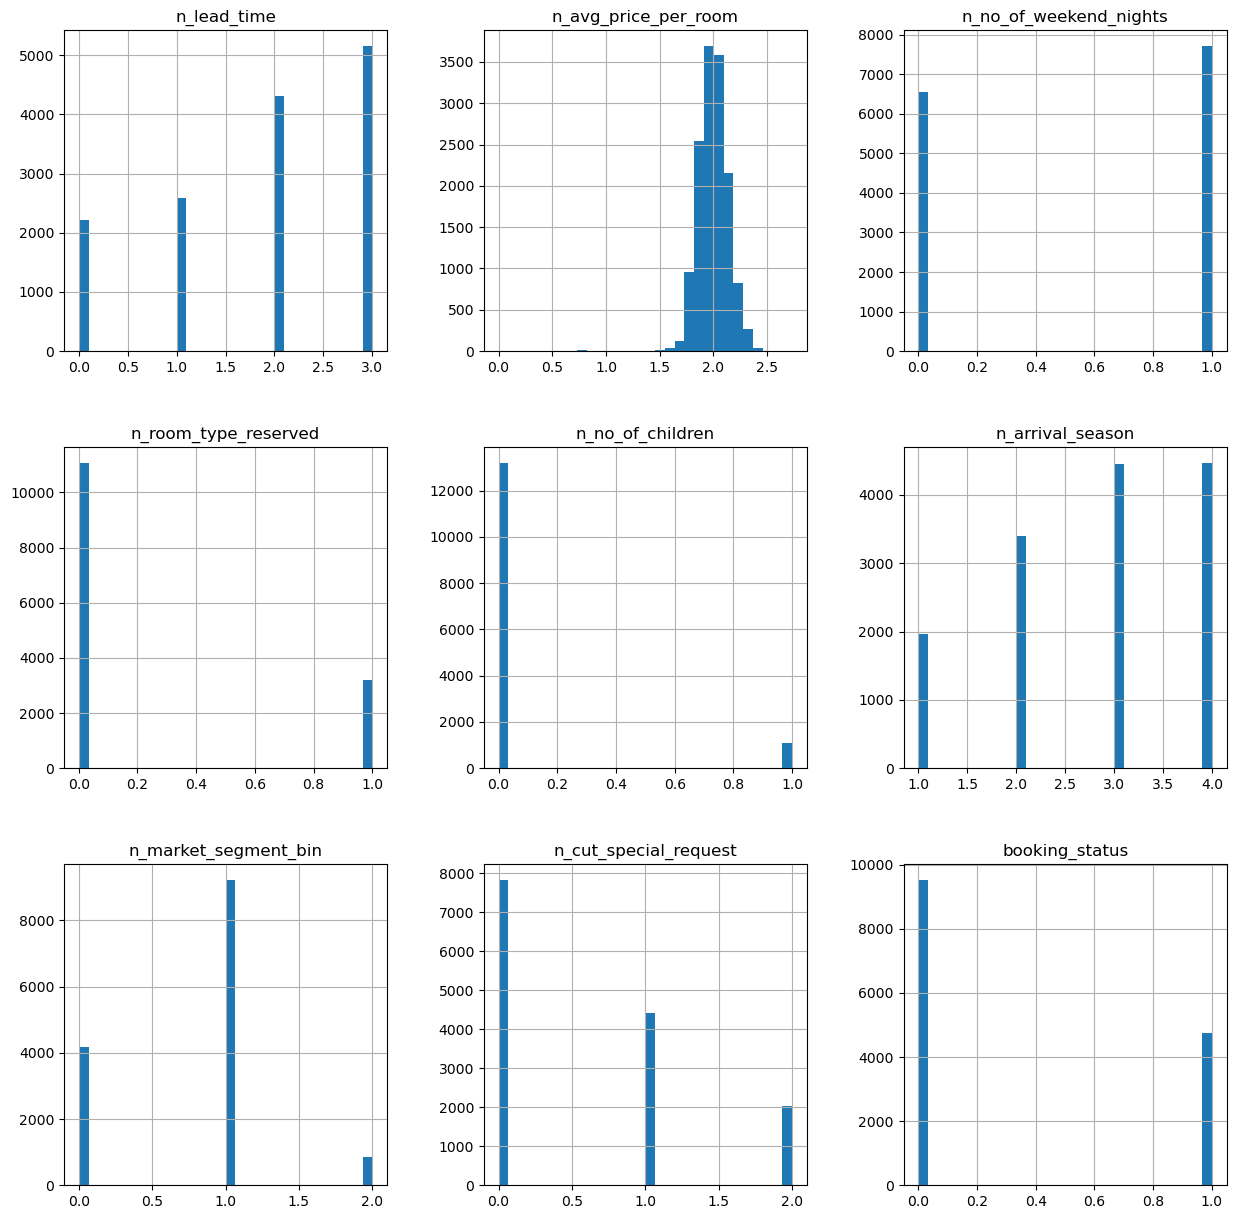

In [18]:
corr_view.hist(bins=30, figsize=(15,15))
plt.show()

In [19]:
corr_view["n_cut_special_request"]

6099     1
10601    0
13388    0
13645    2
13728    1
        ..
17791    2
8260     0
2874     0
7655     0
7239     0
Name: n_cut_special_request, Length: 14282, dtype: int64

Notiz:
lead_time hat die höchste Korrelation <br>
arrival_year wird vermutlich nur eine hohe Korrelation haben weil wir nur zwei Jahre haben, also ein bias - rausnehmen <br>
avg_price_per room würde ich drin lassen- evt gibt es noch eine kombi mit anderen Merkmalen die hilfreich wäre für eine besser Korrelation <br>
no of week nights würde ich noch drin lassen <br>
no of adulds auch und sonst nichts mehr das positiv korreliert

no of special requests sollte definitiv drin bleiben - ein binärmerkmal hat keine bessere korrelation ergeben aber könnte später für modelle evt besser sein zu verarbeiten z.B. Baum <br>
repeated guest hat auch eine hohe negative Korrelation aber der datensatz bietet nur wenige an die wiederholt haben, dass könnte dann auch eher ein bias StopIteration <br>
requiered car parking ist im Endefekt wie repeated guest - hat eine halbwegs hohe korrelation aber könnte auche ein Bias sein <br>



In [20]:
df = pd.read_csv("train_dataset.csv")

In [21]:
df = df[df["avg_price_per_room"] != 0].copy()
#df = df[df["lead_time"] != 0].copy()
df["lead_time"] = df["lead_time"].replace(0, 1)


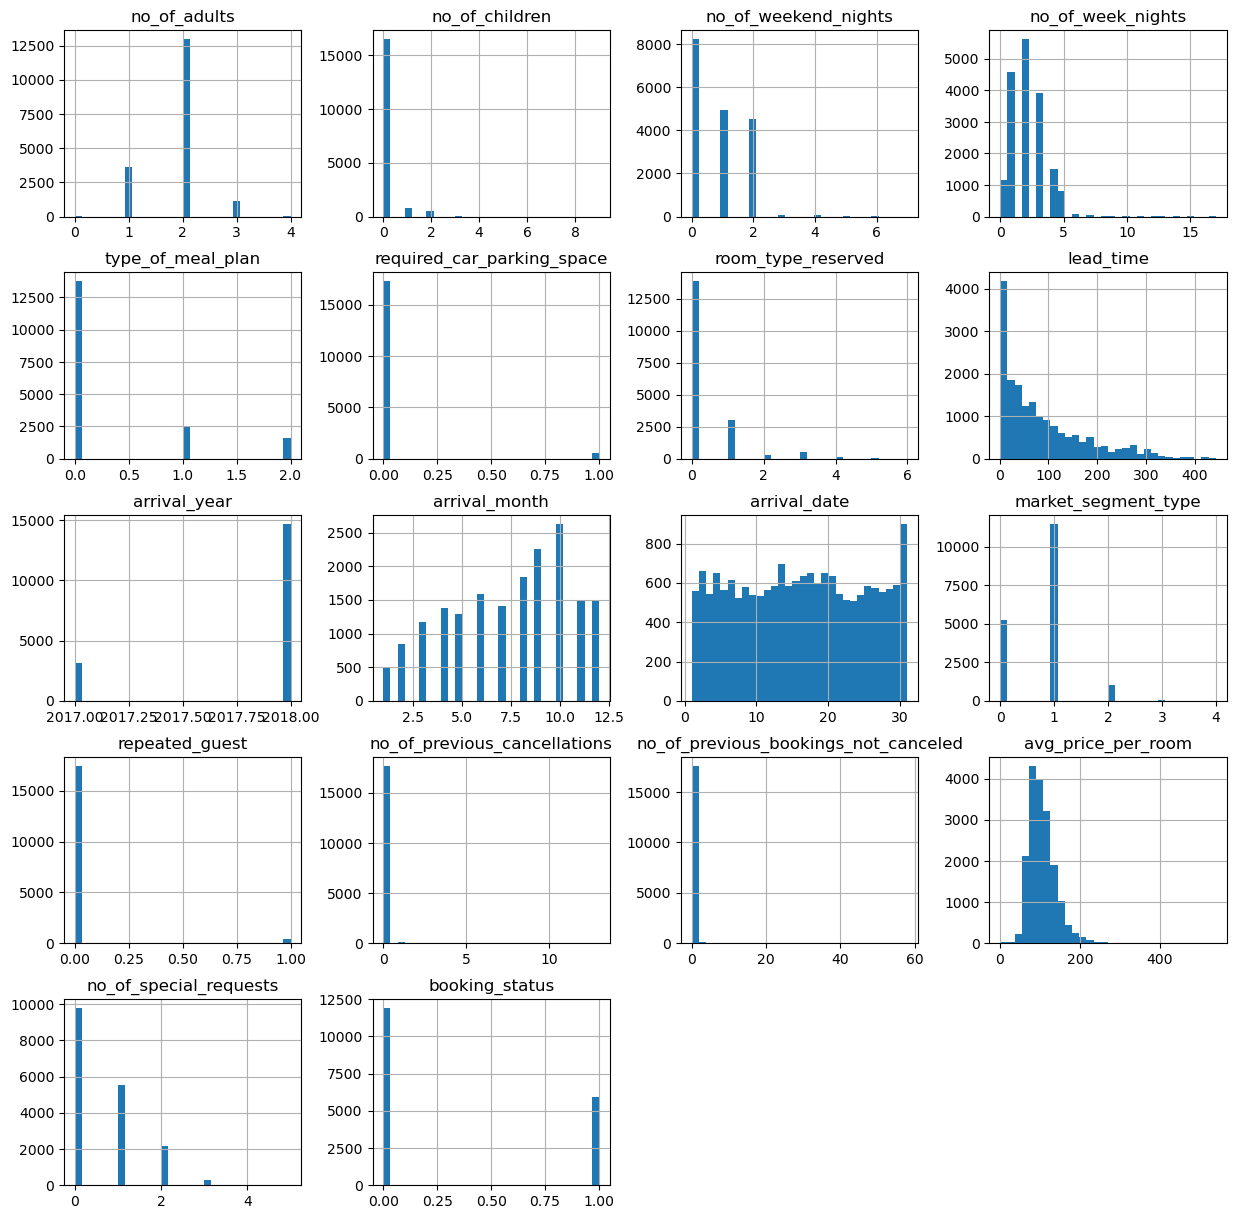

In [22]:
df.hist(bins=30, figsize=(15,15))
plt.show()

In [23]:

def binarize_df(X):
    if isinstance(X, pd.DataFrame):
        return (X > 0).astype(int)
    return (X > 0).astype(int)

def cut_special_request(X):
    s = pd.Series(pd.DataFrame(X).iloc[:, 0])  
    out = pd.cut(s, bins=[-0.5, 0.5, 1.5, np.inf], labels=[0,1,2]).astype(int)
    return out.to_numpy().reshape(-1, 1)

def cut_market_segment(X):
    s = pd.Series(pd.DataFrame(X).iloc[:, 0])
    out = pd.cut(s, bins=[-0.5, 0.5, 1.5, np.inf], labels=[0,1,2], include_lowest=True).astype(int)
    return out.to_numpy().reshape(-1, 1)

def cut_arrival_season(X):
    s = pd.Series(pd.DataFrame(X).iloc[:, 0])
    out = pd.cut(s, bins=[0,3,6,9,12], labels=[1,2,3,4], include_lowest=True).astype(int)
    return out.to_numpy().reshape(-1, 1)


In [24]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, PowerTransformer


#transit_attribs = ["lead_time"]

# zu binäre Attribute 
bin_attribs = [   "no_of_children",
                  "required_car_parking_space",
                  "type_of_meal_plan"
                  ]

# Kategorische Attribute (werden one-hot encodiert)
cat_attribs = [
   "no_of_weekend_nights",
    "room_type_reserved"
    ]

# Numerische Attribute (werden skaliert)
log_scale_attribs = ["avg_price_per_room"]


# Box-Cox Transformation für lead_time
leadtime_pipeline = Pipeline([
    ("boxcox", PowerTransformer(method="box-cox", standardize=True))
])


cat_pipeline = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


bin_pipeline = Pipeline([
    ("bin", FunctionTransformer(binarize_df, validate=False, feature_names_out="one-to-one"))
])

log_scale_pipeline = Pipeline([
    ("log", FunctionTransformer(np.log1p, validate=False, feature_names_out="one-to-one")),
    ("scaler", StandardScaler())
])


special_req_pipeline = Pipeline([
    ("cut_request",FunctionTransformer(cut_special_request, validate=False,feature_names_out="one-to-one")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) 


market_segment_pipeline =Pipeline([
("cut_segment",FunctionTransformer(cut_market_segment, validate=False,feature_names_out="one-to-one")),
("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) 


arrival_season_pipeline =Pipeline([
("cut_season",FunctionTransformer(cut_arrival_season, validate=False,feature_names_out="one-to-one")),
("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
]) 


# zusammenfügen aller Pipelines 
preprocess = ColumnTransformer([
    ("cut_request", special_req_pipeline, ["no_of_special_requests"]),
    ("cut_segment", market_segment_pipeline, ["market_segment_type"]),
    ("cut_season", arrival_season_pipeline, ["arrival_month"]),
    ("bin", bin_pipeline, bin_attribs,),
    ("cat", cat_pipeline, cat_attribs),
    ("log_scale", log_scale_pipeline, log_scale_attribs),
    ("leadtime", leadtime_pipeline, ["lead_time"]),
    
 ])

In [25]:
hoteldata_prepared = pd.DataFrame(
    preprocess.fit_transform(df),
    index=df.index,
    columns=preprocess.get_feature_names_out()
)

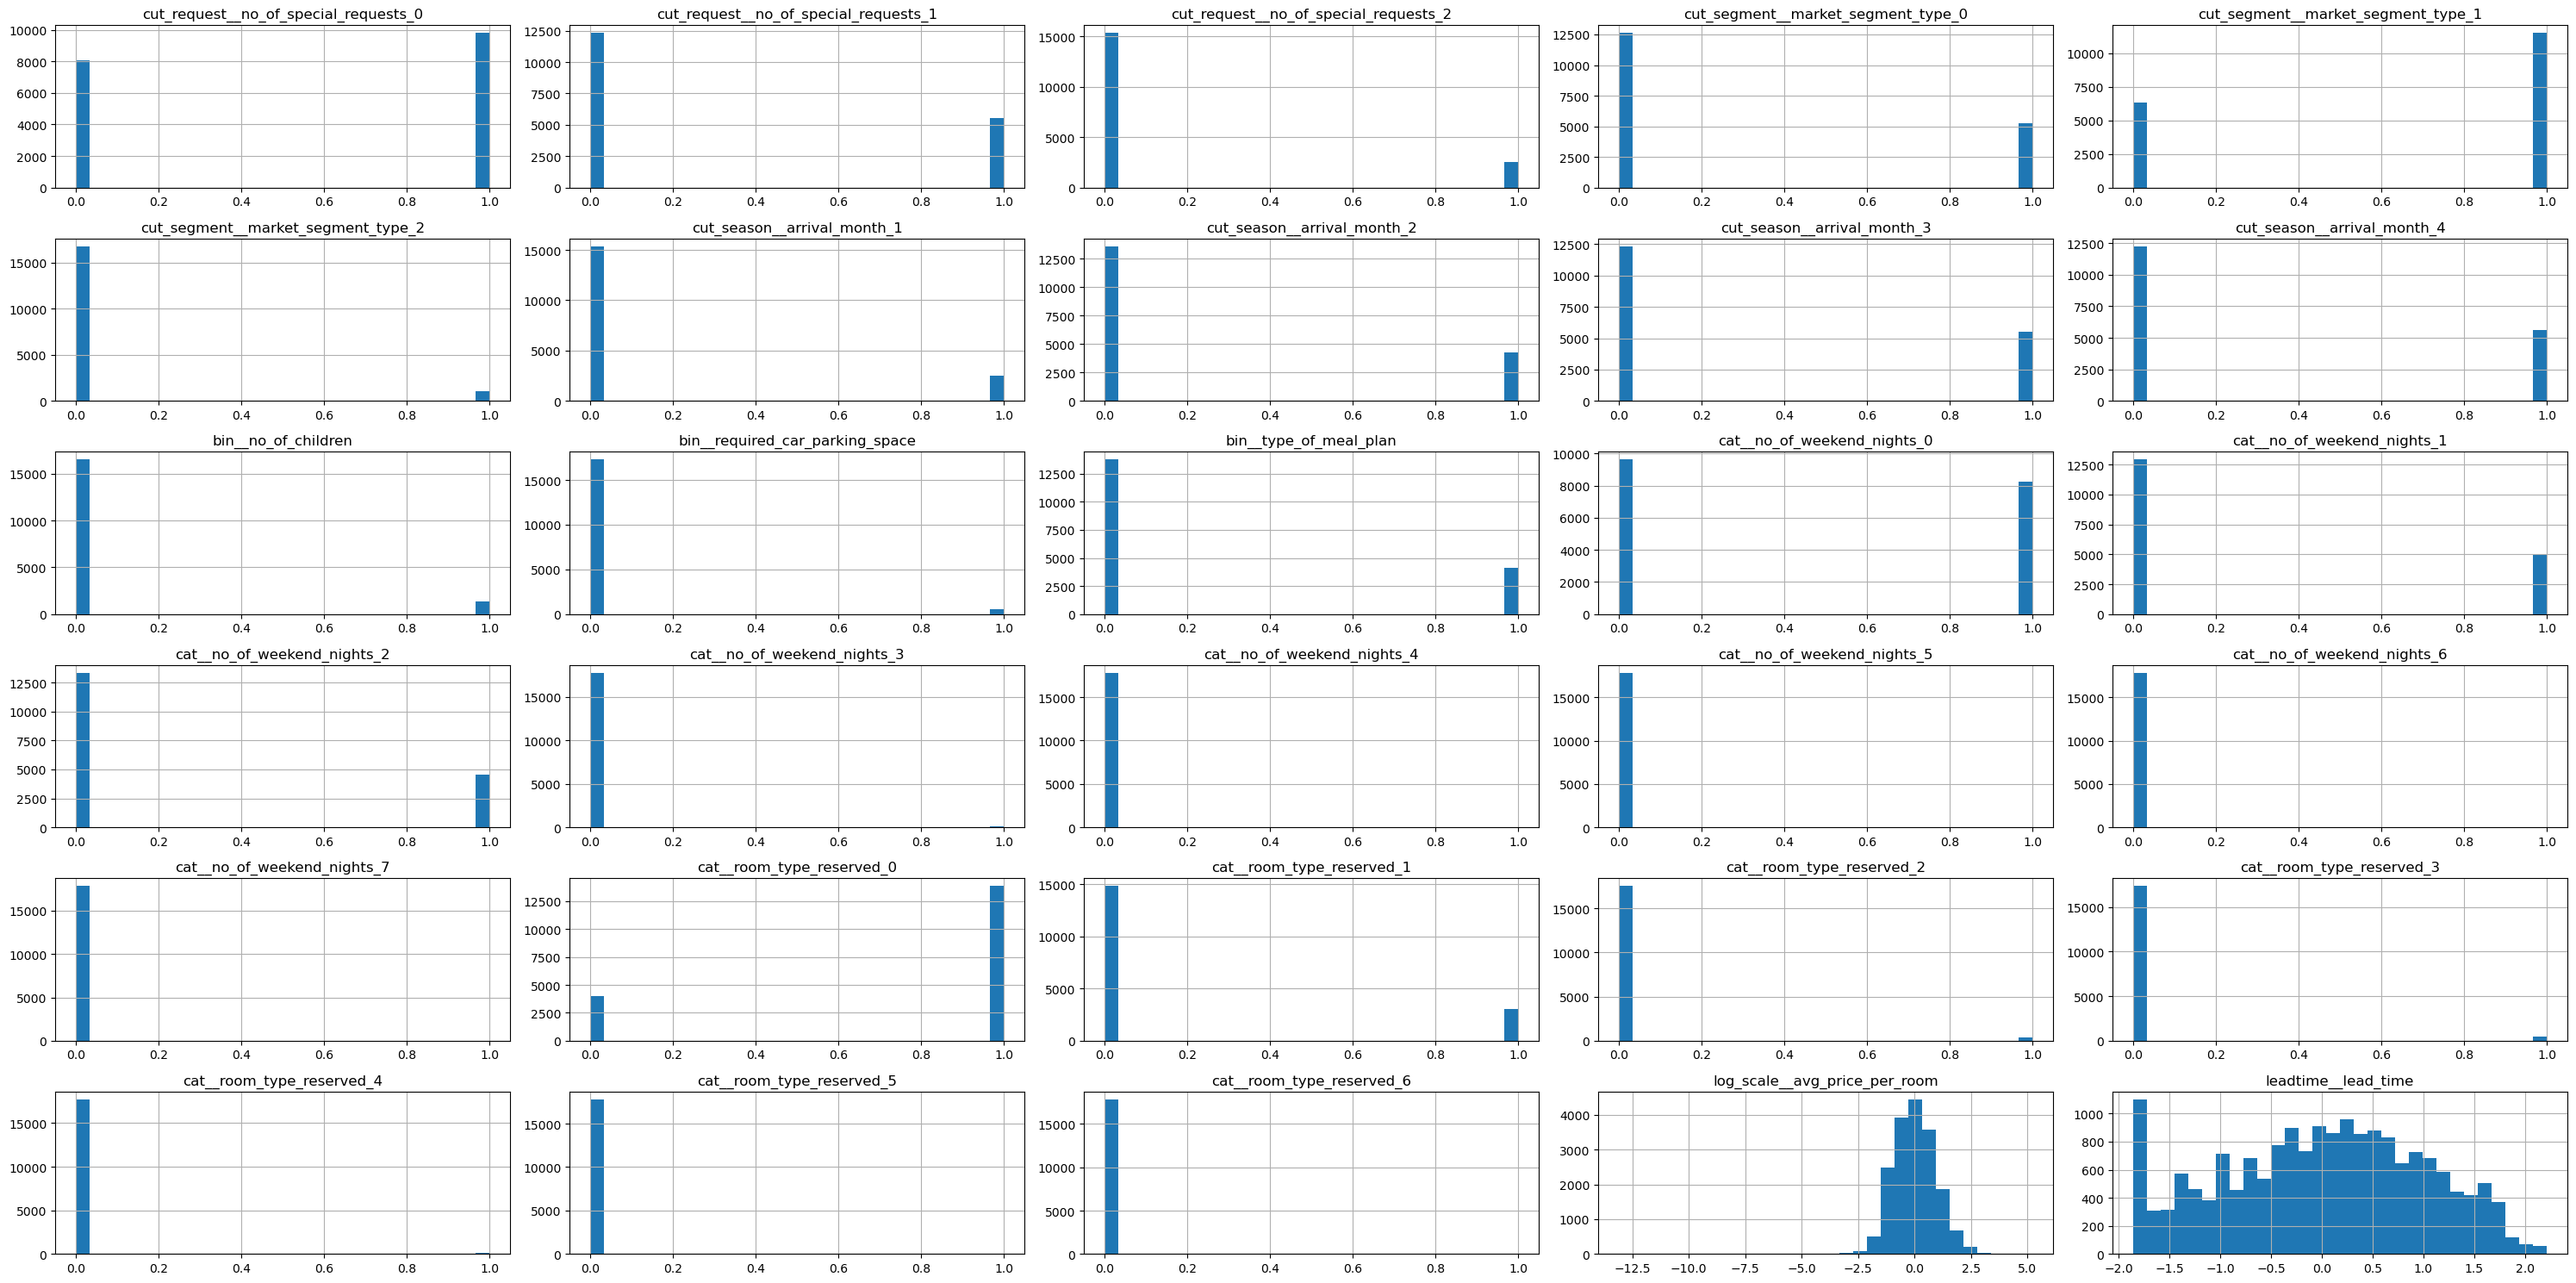

In [26]:
hoteldata_prepared.hist(bins=30, figsize=(30,15))

plt.tight_layout()
plt.show()

In [27]:

X = hoteldata_prepared.copy()
y = df["booking_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [28]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

def evaluate_model(model, X_train, y_train):
    
    # 1. Cross-Validation (nur auf Training!)
    y_train_pred = cross_val_predict(model, X_train, y_train, cv=3, method="predict")
    y_train_proba = cross_val_predict(model, X_train, y_train, cv=3, method="predict_proba")[:, 1]
    print("Cross-Val auf Trainingdaten rf nicht optimiert")
    print(classification_report(y_train, y_train_pred))
    print("ROC-AUC (train):", roc_auc_score(y_train, y_train_proba))

    cm = confusion_matrix(y_train, y_train_pred)
    print(cm)

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Modell erstellen
forest_clf_basis = RandomForestClassifier(
    n_estimators=100,       # Anzahl Bäume
    max_depth=10,           #Anzahl der Ebenen
    random_state=42,        # Zufallsseed
)

#Training
forest_clf_basis.fit(X_train, y_train)

#Model evaluieren
evaluate_model(forest_clf_basis, X_train, y_train)


Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      9532
           1       0.83      0.71      0.77      4750

    accuracy                           0.86     14282
   macro avg       0.85      0.82      0.83     14282
weighted avg       0.85      0.86      0.85     14282

ROC-AUC (train): 0.9134153764604545
[[8839  693]
 [1356 3394]]


In [30]:
from sklearn.linear_model import LogisticRegression

# Modell aufsetzen (l2-Regularisierung, Solver 'liblinear' oder 'lbfgs')
log_clf_basis = LogisticRegression(
    penalty="l2",
    solver="liblinear",   # für kleinere Datensätze stabil
    random_state=42,
    max_iter=3000
)

# Trainieren
log_clf_basis.fit(X_train, y_train)

#Model evaluieren
evaluate_model(log_clf_basis, X_train, y_train)


Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      9532
           1       0.73      0.63      0.68      4750

    accuracy                           0.80     14282
   macro avg       0.78      0.76      0.76     14282
weighted avg       0.79      0.80      0.79     14282

ROC-AUC (train): 0.858022141484639
[[8428 1104]
 [1765 2985]]


In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 5],
    "class_weight": [None, "balanced", "balanced_subsample"]
}

In [32]:
forest_clf_prec = RandomForestClassifier()

#Hyperparameter zur Präzision optimieren
gridf_prec = GridSearchCV(
    estimator=forest_clf_prec,
    param_grid=param_grid,
    cv=5,                   # Kreutzvalidierung Anzahl der Folds
    scoring="precision",    # Fokus auf Präzision
    n_jobs=-1,              # Alle kernel nutzen
    )

gridf_prec.fit(X_train, y_train)
print("Beste Parameter:", gridf_prec.best_params_)

Beste Parameter: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [33]:
forest_clf_recall = RandomForestClassifier()

#Hyperparameter zur Recall optimieren
gridf_recall = GridSearchCV(
    estimator=forest_clf_recall,
    param_grid=param_grid,
    cv=5,               #Kreutzvalidierung Anzahl der Folds
    scoring="recall",   #Hier Fokus auf recall
    n_jobs=-1           #Alle kernel nutzen
)

gridf_recall.fit(X_train, y_train)

print("Beste Parameter:", gridf_recall.best_params_)

Beste Parameter: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}


In [34]:
forest_clf_avg_prec = RandomForestClassifier()

#Hyperparameter zur durchschnittliche Präzision optimieren
gridf_avg_prec = GridSearchCV(
    estimator=forest_clf_avg_prec,
    param_grid=param_grid,   
    cv=5,                        # Kreutzvalidierung Anzahl der Folds
    scoring="average_precision", # Hier Fokus auf average_precision
    n_jobs=-1                    # Alle kernel nutzen
)

gridf_avg_prec.fit(X_train, y_train)

print("Beste Parameter:", gridf_prec.best_params_)

Beste Parameter: {'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [35]:
forest_clf_prec = RandomForestClassifier(
    n_estimators      = gridf_prec.best_params_.get("n_estimators"),
    max_depth         = gridf_prec.best_params_.get("max_depth"),
    min_samples_split = gridf_prec.best_params_.get("min_samples_split"),
    min_samples_leaf  = gridf_prec.best_params_.get("min_samples_leaf"),
    class_weight      = gridf_prec.best_params_.get("class_weight"),
    random_state=42,
    n_jobs=-1
)
# Training
forest_clf_prec.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [36]:
forest_clf_avg_prec = RandomForestClassifier(
    n_estimators      = gridf_avg_prec.best_params_.get("n_estimators"),
    max_depth         = gridf_avg_prec.best_params_.get("max_depth"),
    min_samples_split = gridf_avg_prec.best_params_.get("min_samples_split"),
    min_samples_leaf  = gridf_avg_prec.best_params_.get("min_samples_leaf"),
    class_weight      = gridf_avg_prec.best_params_.get("class_weight"),
    random_state=42,
    n_jobs=-1
)


#Training
forest_clf_avg_prec.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=400, n_jobs=-1,
                       random_state=42)

In [37]:
forest_clf_recall = RandomForestClassifier(
    n_estimators      = gridf_recall.best_params_.get("n_estimators", 200),
    max_depth         = gridf_recall.best_params_.get("max_depth", None),
    min_samples_split = gridf_recall.best_params_.get("min_samples_split", 2),
    min_samples_leaf  = gridf_recall.best_params_.get("min_samples_leaf", 1),
    class_weight      = gridf_recall.best_params_.get("class_weight", None),
    random_state=42,
    n_jobs=-1
)


# Training
forest_clf_recall.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=5, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [38]:
#Model precistion evaluieren
evaluate_model(forest_clf_prec, X_train, y_train)

Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.89      0.93      0.90      9532
           1       0.84      0.76      0.80      4750

    accuracy                           0.87     14282
   macro avg       0.86      0.84      0.85     14282
weighted avg       0.87      0.87      0.87     14282

ROC-AUC (train): 0.9251771981359189
[[8820  712]
 [1140 3610]]


In [39]:

#Model recall evaluieren
evaluate_model(forest_clf_recall, X_train, y_train)

Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      9532
           1       0.76      0.82      0.79      4750

    accuracy                           0.85     14282
   macro avg       0.83      0.84      0.84     14282
weighted avg       0.86      0.85      0.85     14282

ROC-AUC (train): 0.9157358813525631
[[8299 1233]
 [ 877 3873]]


In [40]:

#Model Forest avg Precision evaluieren
evaluate_model(forest_clf_avg_prec, X_train, y_train)

Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      9532
           1       0.82      0.77      0.80      4750

    accuracy                           0.87     14282
   macro avg       0.86      0.84      0.85     14282
weighted avg       0.87      0.87      0.87     14282

ROC-AUC (train): 0.9249675110983502
[[8726  806]
 [1077 3673]]


In [41]:
# Hyperparameter Bereich für logistische Regression
param_grid_log = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10, 100],          # Regularisierungsstärke
    "solver": ["liblinear", "saga"],       # beide unterstützen l1
    "class_weight": [None, "balanced"]
}


In [42]:
log_clf_prec = LogisticRegression(max_iter=3000)

# GridSearch mit Precision als Ziel
gridl_prec = GridSearchCV(
    estimator=log_clf_prec,
    param_grid=param_grid_log,
    cv=5,#cv,
    scoring="precision",
    n_jobs=-1,
)

gridl_prec.fit(X_train, y_train)

print("Beste Parameter (Precision):", gridl_prec.best_params_)


Beste Parameter (Precision): {'C': 0.01, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}


In [43]:
# GridSearch mit Recall als Ziel
log_clf_recall = LogisticRegression(max_iter=3000)

gridl_recall = GridSearchCV(
    estimator=log_clf_recall,
    param_grid=param_grid_log,
    cv=5,#cv,
    scoring="recall",
    n_jobs=-1,
)

gridl_recall.fit(X_train, y_train)

print("Beste Parameter (Recall):", gridl_recall.best_params_)


Beste Parameter (Recall): {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [44]:
log_clf_prec = LogisticRegression(
    penalty      = gridl_prec.best_params_["penalty"],
    C            = gridl_prec.best_params_["C"],
    solver       = gridl_prec.best_params_["solver"],
    class_weight = gridl_prec.best_params_["class_weight"],
    random_state = 42,
    max_iter     = 4000
)

# Trainieren
log_clf_prec.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=4000, random_state=42, solver='saga')

In [45]:
log_clf_recall = LogisticRegression(
    penalty      = gridl_recall.best_params_["penalty"],
    C            = gridl_recall.best_params_["C"],
    solver       = gridl_recall.best_params_["solver"],
    class_weight = gridl_recall.best_params_["class_weight"],
    random_state = 42,
    max_iter     = 4000
)

# Trainieren
log_clf_recall.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight='balanced', max_iter=4000,
                   random_state=42, solver='liblinear')

In [46]:
#Model logistic regression precision evaluieren
evaluate_model(log_clf_prec, X_train, y_train)

Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      9532
           1       0.76      0.60      0.67      4750

    accuracy                           0.80     14282
   macro avg       0.79      0.75      0.76     14282
weighted avg       0.80      0.80      0.80     14282

ROC-AUC (train): 0.8529359387768626
[[8626  906]
 [1923 2827]]


In [47]:
#Model logistic regression recall evaluieren
evaluate_model(log_clf_recall, X_train, y_train)


Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      9532
           1       0.61      0.80      0.70      4750

    accuracy                           0.77     14282
   macro avg       0.75      0.78      0.75     14282
weighted avg       0.79      0.77      0.77     14282

ROC-AUC (train): 0.8533694480641385
[[7138 2394]
 [ 944 3806]]


In [48]:

# Random Forest – best params aus deinem RF-Grid (ohne Pipeline)
rf_best = RandomForestClassifier(
    n_estimators      = gridf_prec.best_params_["n_estimators"],
    max_depth         = gridf_prec.best_params_["max_depth"],
    min_samples_split = gridf_prec.best_params_["min_samples_split"],
    min_samples_leaf  = gridf_prec.best_params_["min_samples_leaf"],
    class_weight      = gridf_prec.best_params_["class_weight"],
    random_state=42,
    n_jobs=-1
)

# Logistic Regression – nimm z.B. die PRECISION-optimierten Params
lr_best_prec = LogisticRegression(
    penalty      = gridl_prec.best_params_["penalty"],
    C            = gridl_prec.best_params_["C"],
    solver       = gridl_prec.best_params_["solver"],
    class_weight = gridl_prec.best_params_["class_weight"],
    random_state = 42,
    max_iter     = 4000
)

In [49]:
#Ensemble mit VotingClassifier
from sklearn.ensemble import VotingClassifier


vclf = VotingClassifier(
    estimators=[("rf", rf_best), ("lr", lr_best_prec)],
    voting="soft",
    weights=[1, 1],   # z.B. [2,1], wenn RF mehr Gewicht bekommen soll
    n_jobs=-1
)

vclf.fit(X_train, y_train)

#Model Ensemble evaluieren
evaluate_model(vclf, X_train, y_train)


Cross-Val auf Trainingdaten rf nicht optimiert
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      9532
           1       0.84      0.71      0.77      4750

    accuracy                           0.86     14282
   macro avg       0.85      0.82      0.83     14282
weighted avg       0.86      0.86      0.86     14282

ROC-AUC (train): 0.9141545707533627
[[8882  650]
 [1368 3382]]
